#Set Up

Run either ```#Import PiF``` or ```#Local Pif```

*7/3/2024 - Local Pif is recommended*

*7/5/2024 - In Jupyter lab you can use ```%matplotlib ipybmpl``` to have animations run inline but in Google colab this does not work so I have commented out animation related code in the ```simulate()``` function.*

*Additionally, when attempting to allow simulations to be made on the same plot there was some interference between the animation and overlay functionality so in this notebook all animations will not work and if using the PiF.py functions in a Jupyter Notebook or otherwise then plots will not overlap.*

In [1]:
#Import PiF
#from PiF import *
#import matplotlib
#%matplotlib ipympl

In [2]:
#Local PiF
'''
Particle in Field Simulations
(MATLAB) v1: N Cicotte & JA Riousset ©2020
(MATLAB) v2: JA Riousset ©2022
(Python) v3: Seth Gerow 2024
'''
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from numpy import linalg
from math import *

class b_field:
    '''
    This class defines a magnetic field.
    mag is the magnitude of the field.
    btype specifies how the magnetic feild vector should be calcualted from the magnitude:
    "Bx, By, Bz, null, gradB, dipole, bottle, user"
    beta is the coefficient for the magnetic field default = 0
    N is the number of magnetic field lines to show default = 7
    '''
    rRef = 1
    def __init__(self, btype = "null", mag = 1, beta = 0, N = 7):
        self.btype = btype
        self.magnitude = mag
        self.beta = beta
        self.field_lines = N
    def get_field(self, X):
        x = float(X[0])
        y = float(X[1])
        z = float(X[2])
        r = sqrt(x**2 + y**2 + z**2)
        btype = self.btype
        if r != 0:
            match btype:
                case "null":
                    Bx = 0
                    By = 0
                    Bz = 0
                case "Bx":
                    Bx = self.magnitude
                    By = 0
                    Bz = 0
                case "By":
                    Bx = 0
                    By = self.magnitude
                    Bz = 0
                case "Bz":
                    Bx = 0
                    By = 0
                    Bz = self.magnitude
                case "user":
                    Bx = 0
                    By = 0
                    Bz = 0
                case "dipole":
                    Bx = self.magnitude*self.rRef**3*(3*x*z)/r**5
                    By = self.magnitude*self.rRef**3*(3*y*z)/r**5
                    Bz = self.magnitude*self.rRef**3*(3*z**2-r**2)/r**5
                case "bottle":
                    Bx = self.magnitude*(-1*self.beta**2*x*z)
                    By = self.magnitude*(-1*self.beta**2*y*z)
                    Bz = self.magnitude*(1+self.beta**2*z**2)
                case "gradB":
                    Bx = 0
                    By = 0
                    Bz = self.magnitude*(1+self.beta*y)
        else:
            Bx = 0
            By = 0
            Bz = 0
        B = np.array([Bx,By,Bz])
        return B

class e_field:
    def __init__(self, etype = "null", mag = 0.01, alpha = 0.05):
        self.etype = etype
        self.magnitude = mag
        self.alpha = alpha
    def get_field(self,X):
        x = float(X[0])
        y = float(X[1])
        z = float(X[2])
        r = sqrt(x**2 + y**2 + z**2)
        etype = self.etype
        if r != 0:
            match etype:
                case "null":
                    Ex = 0
                    Ey = 0
                    Ez = 0
                case "Ex":
                    Ex = self.magnitude
                    Ey = 0
                    Ez = 0
                case "Ey":
                    Ex = 0
                    Ey = self.magnitude
                    Ez = 0
                case "Ez":
                    Ex = 0
                    Ey = 0
                    Ez = self.magnitude
                case "user":
                    Ex = self.magnitude*cos(self.alpha*x)
                    Ey = 0
                    Ez = 0
        else:
            Ex = 0
            Ey = 0
            Ez = 0
        E = np.array([Ex,Ey,Ez])
        return E

class particle:
    def __init__(self, q = 1, m = 1, name = "particle"):
        self.name = name
        self.charge = q
        self.mass = m

def solver(particle, efield, bfield, R0, V0, t0, tf):
    def eom(t,X):
        x = X[0]
        y = X[1]
        z = X[2]
        vx = X[3]
        vy = X[4]
        vz = X[5]
        R = np.array([x,y,z])
        V = np.array([vx,vy,vz])
        F = Lorentz_Force(X)
        Fx = F[0]
        Fy = F[1]
        Fz = F[2]
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        dX = np.array([vx,vy,vz,ax,ay,az])
        return dX

    def Lorentz_Force(X):
        x = X[0]
        y = X[1]
        z = X[2]
        vx = X[3]
        vy = X[4]
        vz = X[5]
        R = np.array([x,y,z])
        E = efield.get_field(R)
        B = bfield.get_field(R)
        V = np.array([vx,vy,vz])
        F = q*(E + np.cross(V,B))
        return F

    def velocity(V,B,vtype = "vpp"):
        b = linalg.norm(B)
        vpp = linalg.norm(np.cross(V,B))/b
        vpr = int(np.dot(V,B))/b
        match vtype:
            case "vpp":
                return vpp
            case "vpr":
                return vpr

    m = particle.mass
    q = particle.charge
    X0 = np.concatenate([np.transpose(R0),np.transpose(V0)])
    E0 = efield.get_field(X0)
    B0 = bfield.get_field(X0)
    b0 = linalg.norm(B0)
    wg = abs(particle.charge)*b0/particle.mass
    Tg = 2*pi/wg
    vpp0 = velocity(V0,B0, vtype = "vpp")
    rg = vpp0/wg
    N = round(tf/Tg)
    print(f"Simulation Running for {N} Gyro Period")
    t_span = (t0,tf)

    sol = solve_ivp(eom, t_span, X0, max_step = 0.01)
    return sol

def simulate(initial_conditions, axis = None, speed='real', title='Simulation of Particle in a Field', view='3D', earth=False, overlay=False):
    '''initial_conditions takes the form of a tuple or list containing a particle object, field objects, and initial
    position and velocity values as numpy arrays size (3,), as well as an initial time and final time.

    initial conditions = (particle, e_field, b_field, R0 = np.array([x,y,z]), V0 = np.array([vx,vy,vz]), t0, tf)

    speed:  'real' - real time speed
            'slow' - 1/2x speed

    view:   '3D' - 3d view
            'x-y'
            'y-z'
            'x-z'
    '''
    particle, efield, bfield, R0, V0, t0, tf = initial_conditions
    sol = solver(particle, efield, bfield, R0, V0, t0, tf)
    t = sol.t
    x = sol.y[0]
    y = sol.y[1]
    z = sol.y[2]

    colors = ['black', 'blue', 'green', 'red']
    if not overlay or axis is None:  # Create a new figure if overlay is False or axis is None
        fig = plt.figure()
        new_plot = True
        color = colors[0]
    else:
        fig = axis.figure  # Use the existing figure if overlay is True
        new_plot = False
        color = colors[len(list(axis.get_legend().get_texts()))]

    print(f"Overlay: {overlay}, New plot: {new_plot}, View: {view}, Color: {color}")

    if view == "3D":
        if new_plot:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = axis
        ax.plot(x, y, z, color=color, label=particle.name)
        ax.axis('equal')
        ax.set_xlabel('x(m)')
        ax.set_ylabel('y(m)')
        ax.set_zlabel('z(m)')
        ax.view_init(elev=20, azim=45)
        #particle_point, = ax.plot([], [], [], 'ro', label=particle.name)
        #time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes)
    elif view == "x-y":
        if new_plot:
            ax = fig.add_subplot(111)
        else:
            ax = axis
        ax.plot(x, y, color=color, label=particle.name)
        ax.axis('equal')
        ax.set_xlabel('x(m)')
        ax.set_ylabel('y(m)')
        #particle_point, = ax.plot([], [], 'ro', label=particle.name)
        #time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)
    elif view == "y-z":
        if new_plot:
            ax = fig.add_subplot(111)
        else:
            ax = axis
        ax.plot(y, z, color=color, label=particle.name)
        ax.axis('equal')
        ax.set_xlabel('y(m)')
        ax.set_ylabel('z(m)')
        #particle_point, = ax.plot([], [], 'ro', label=particle.name)
        #time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)
    elif view == "x-z":
        if new_plot:
            ax = fig.add_subplot(111)
        else:
            ax = axis
        ax.plot(x, z, color=color, label=particle.name)
        ax.axis('equal')
        ax.set_xlabel('x(m)')
        ax.set_ylabel('z(m)')
        #particle_point, = ax.plot([], [], 'ro', label=particle.name)
        #time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

    ax.grid(False)
    ax.set_title(title)  # Update the title even when overlaying
    ax.legend()
    '''
    def update(num, x, y, z, particle_point, time_text):
        print(f"Updating frame {num} with view {view}...")
        if view == "3D":
            particle_point.set_data([x[num]], [y[num]])  # Pass sequences
            particle_point.set_3d_properties([z[num]])  # Pass sequences
        elif view == "x-y":
            particle_point.set_data([x[num]], [y[num]])  # Pass sequences
        elif view == "y-z":
            particle_point.set_data([y[num]], [z[num]])  # Pass sequences
        elif view == "x-z":
            particle_point.set_data([x[num]], [z[num]])  # Pass sequences
        time_text.set_text(f'Time: {t[num]:.2f}s')
        return particle_point, time_text

    # blit = False for Jupyter Lab, blit = true otherwise
    interval = 0 if speed == 'real' else 2
    ani = FuncAnimation(fig, update, frames=len(t), fargs=(x, y, z, particle_point, time_text), interval=interval, blit=False, repeat=False)

    global animation
    animation = ani
    '''
    #plt.show(fig)

    return ax#, ani

def test():
    example_particle = particle(q=-1)
    efield = e_field(etype = "null", mag = 0.01, alpha = 0.05)
    bfield = b_field(btype = "dipole", mag = -1, beta = 0.1)
    R0 = np.array([1,0,0])
    V0 = np.array([0.04,0.04,0.07])
    t0 = 0
    tf = 1200
    speed = 'real'

    IC = (example_particle, efield, bfield, R0, V0, t0, tf)
    title = 'Movement of a Negatively Charged Particle in a Dipole Magnetic Field'
    simulate(IC, speed, title, earth = True)

#Particle in Field Project

**(P1)** *(5 points)*

Consider the motion of a charged particle with charge $q = 1$, mass $m = 1$ in the homogeneous magnetic field $\vec{B} = 1 \hat{k}$. Assum that this particle starts at the origin $\vec{r}(0) = \vec{0}$ with the initial velocity $\vec{v}(0) = v_0\hat{\imath} = 1\hat{\imath}$

(1.1) What is the trajectory of this particle in the *x-y* plane? What is the direction of rotation with respect to the magnetic field?

>Because you have not worked with this package or seen any explicit examples yet I will use this first problem as an example. Feel free to look at the intructor version if you get stuck on later problems but try to complete the project with no help.



<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black
Simulation Running for 0 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: blue


<Axes: title={'center': 'Overlayed Simulations in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

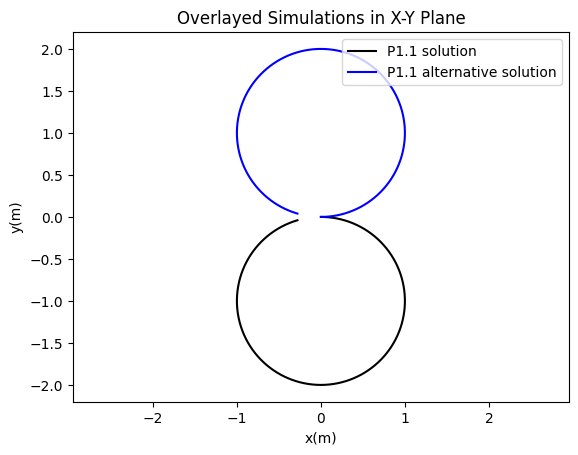

In [3]:
#First we need to define our particle and fields for the question.
#Since this is P1.1 I will name fields and particles as _11 and for P1.2 I will use _12 and so on.
#The question gives us a particle with mass 1 and charge 1:
P11 = particle(q=1,m=1,name='P1.1 solution')

#A magnetic field of magnitude 1, but only in the z direction. Meaning we have a Bz field of mag 1. No beta was given
B11 = b_field(btype = 'Bz', mag = 1, beta = 0)

#The question did not include an electric field so we will use type 'null'
E11 = e_field(etype = 'null')

#Our particle starts at R = (0,0,0) and V = (1,0,0). You can use an arbitrary t_span but 6 seconds is just below a full
#gyro period
#Pass all of our initial conditions into a tuple names IC
IC11 = (P11, E11, B11, np.array([0,0,0]), np.array([1,0,0]), 0, 6)

#simulate the particle movement at real speed (this means that the animation will show one second passing in about a
#real life second), a descriptive title, and a relavent view. If you plan to make multiple plots that use the same view
#for comparison you should assign this simulation to a variable so you can use the same plot again later
sim1 = simulate(IC11,axis = None, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

#If you want to simulate two different paths but use the same view and overlay them you can call your simulation variable as the "axis" parameter.
P12 = particle(q=-1,m=1,name='P1.1 alternative solution')
IC12 = (P12, E11, B11, np.array([0,0,0]), np.array([1,0,0]), 0, 6)
simulate(IC12, axis=sim1, speed = 'real', title = "Overlayed Simulations in X-Y Plane", view = 'x-y', overlay = True)

(1.2) How do changes in the particle sign, mass, and magnitude of the ambient magnetic field affect the particle trajectory? Perform separate experiments by changing those parameters.

*While I do not encourage using AI to do all of your work for you, if you get stuck, you can prompt the google AI to help you work through problems. For exampl, I provided the following prompt and got this result ```Can you explain how I would use simulate() to show how the trajectory of particle P11 would be different with a different charge, mass, or magnetic field magnitude?```:*

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black
Simulation Running for 0 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: blue
Simulation Running for 0 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: green


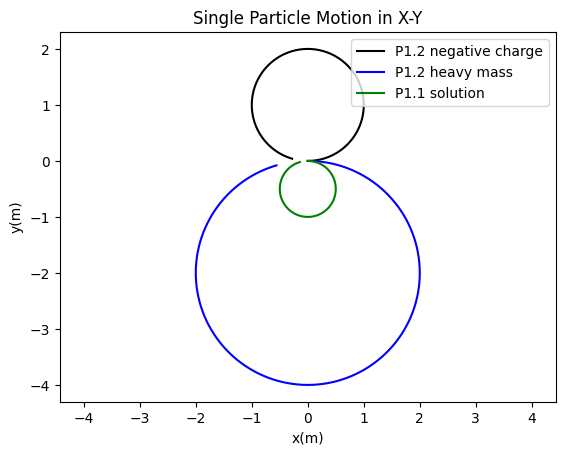

In [4]:
# prompt: Can you explain how I would use simulate() to show how the trajectory of particle P11 would be different with a different charge, mass, or magnetic field magnitude?
P11 = particle(q=1,m=1,name='P1.1 solution')
B11 = b_field(btype = 'Bz', mag = 1, beta = 0)
E11 = e_field(etype = 'null')

#To change the charge of the particle you can either define a new particle
P12_negative = particle(q=-1,m=1,name='P1.2 negative charge')
#or you can change the charge of the particle already defined
#P11.charge = -1

#To change the mass of a particle you can either define a new particle
P12_heavy = particle(q=1,m=2,name='P1.2 heavy mass')
#or you can change the mass of the particle already defined
#P11.mass = 2

#To change the magnitude of the magnetic field you can either define a new field
B12_strong = b_field(btype = 'Bz', mag = 2, beta = 0)
#or you can change the magnitude of the field already defined
#B11.magnitude = 2

#Then to simulate these changes you can just change the initial conditions tuple
#For example to simulate a particle with negative charge
IC_negative = (P12_negative, E11, B11, np.array([0,0,0]), np.array([1,0,0]), 0, 6)
sim12 = simulate(IC_negative, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

#Or to simulate a particle with a larger mass
IC_heavy = (P12_heavy, E11, B11, np.array([0,0,0]), np.array([1,0,0]), 0, 12)
sim12 = simulate(IC_heavy, axis = sim12, speed = 'real', title = 'Single Particle Motion in X-Y', view = 'x-y', overlay = True)

#Or to simulate a particle in a stronger magnetic field
IC_strong = (P11, E11, B12_strong, np.array([0,0,0]), np.array([1,0,0]), 0, 3)
sim12 = simulate(IC_strong, axis = sim12, speed = 'real', title = 'Single Particle Motion in X-Y', view = 'x-y', overlay = True)


**P1.2 Solution**
>The particle with a negative charge rotates counter clockwise due to the charge-sign dependency in $F = q\vec{v}\times\vec{B}$

>Gyro-Radius is $r_g = \frac{mv}{qB}$ so if $v$ is unchanged then doubling the mass will double the radius.

>Gyro-radius is inversly proportional to $B$ so doubling $|B|$ will halve the radius.

(1.3) If the initial velocity is changed to $\vec{v}(0) = 1\hat{\imath} + 2\hat{k}$. What is the trajectory of the particle in this case?

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: 3D, Color: black


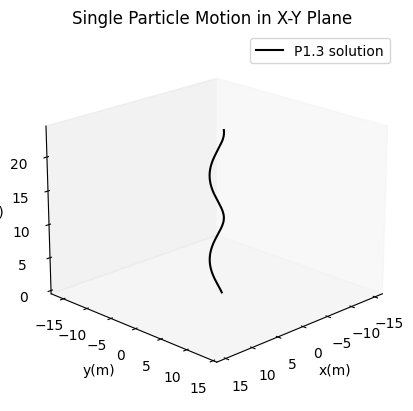

In [5]:
P13 = particle(q=1,m=1,name='P1.3 solution')
B13 = b_field(btype = 'Bz', mag = 1, beta = 0)
E13 = e_field(etype = 'null')
IC = (P13, E13, B13, np.array([0,0,0]), np.array([1,0,2]), 0, 12)
sim13 = simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = '3D')

**P1.3 Solution**

>The z-component of the velocity give the particle vertical motion which results in a helical trajectory.

**(P2)** *(5 points)*

The $\vec{E}$-drift velecity can be shown to be $\vec{v}_\vec{E} = \frac{\vec{E}\times\vec{B}}{B^2}$. Consider the same initial conditions in **(P1)** but with the  non-zero ambient electric field $\vec{E} = 0.1\hat{k}$.

(2.1) How does the trajectory look in the *x-z* plane? in the *x-y* plane?

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-z, Color: black
Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black


<Axes: title={'center': 'Single Particle Motion in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

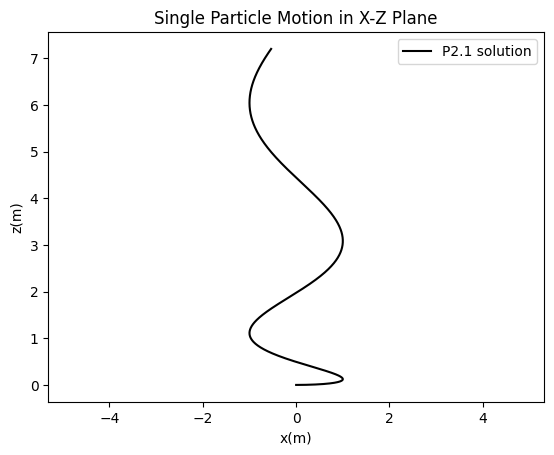

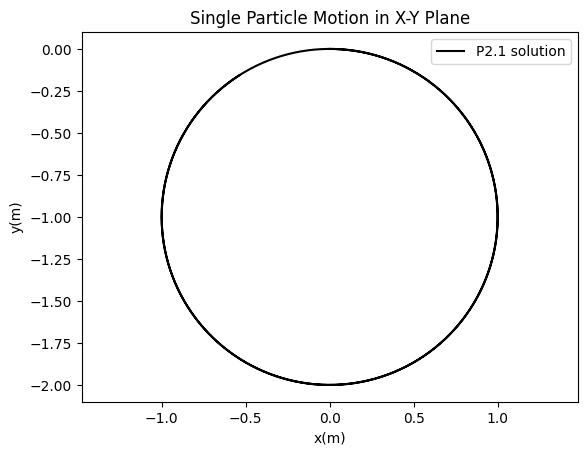

In [6]:
P211 = particle(q=1,m=1,name='P2.1 solution')
B211 = b_field(btype = 'Bz', mag = 1, beta = 0)
E211 = e_field(etype = 'Ez', mag = 0.1)

P212 = particle(q=1,m=1,name='P2.1 solution')
B212 = b_field(btype = 'Bz', mag = 1, beta = 0)
E212 = e_field(etype = 'Ez', mag = 0.1)

IC = (P211, E211, B211, np.array([0,0,0]), np.array([1,0,0]), 0, 12)
simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Z Plane', view = 'x-z')
IC = (P212, E212, B212, np.array([0,0,0]), np.array([1,0,0]), 0, 12)
simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

**P2.1 Solution**
>The particle in the x-y plane is only affected by the magnetic field and therefore appears to have a circular trajectory.

>The particle in the x-z plane displays the impact of the electric field in the vertical direction due to the Lorentz Force $F = q\vec{E} + q\vec{v}\times\vec{B}$. The vertical component of the force causes an acceleration in the z-direction.

(2.2) Let $\vec{E} = 0.5 \hat{\imath}$. What direction and velocity of the guiding center drift in this case? How does the direction change with the particle sign?

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black
Simulation Running for 0 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: blue


<Axes: title={'center': 'Single Particle Motion in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

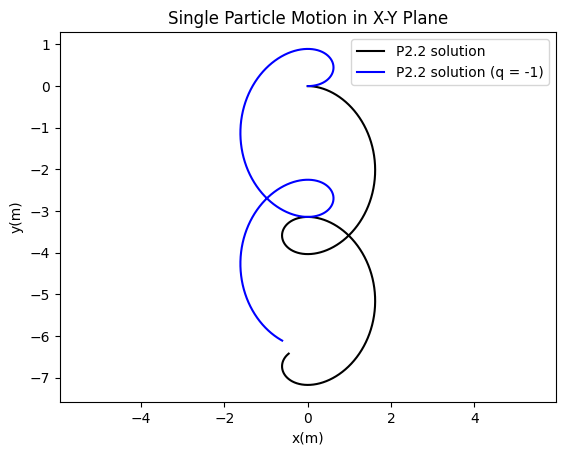

In [7]:
P221 = particle(q=1,m=1,name='P2.2 solution')
B221 = b_field(btype = 'Bz', mag = 1, beta = 0)
E221 = e_field(etype = 'Ex', mag = 0.5)

P222 = particle(q=-1,m=1,name='P2.2 solution (q = -1)')
B222 = b_field(btype = 'Bz', mag = 1, beta = 0)
E222 = e_field(etype = 'Ex', mag = 0.5)


IC = (P221, E221, B221, np.array([0,0,0]), np.array([1,0,2]), 0, 12)
sim22 = simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')
IC = (P222, E222, B222, np.array([0,0,0]), np.array([1,0,2]), 0, 12)
simulate(IC, axis = sim22, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y', overlay = True)

**P2.2 Solution**
>The drift velocity due to an electric field is given by $\vec{v}_\vec{E} = \frac{\vec{E}\times\vec{B}}{B^2}$, which in this case simplifies to $\vec{v}_\vec{E} =-\frac{E}{B}\hat{\jmath}$. This means that the particle will drift in the negative y direction which is apparent in the x-y view.

>Because the drift velocity is charge independent the sign change will not change the direction of drift ($-\hat{\jmath}$), but will reverse the direction of rotation from clockwise to counter-clockwise.

(2.3) Still considering $\vec{B} = 1\hat{k}$ and $\vec{E} = 0.5\hat{\imath}$, with $\vec{r}(0) = 1\hat{\imath}$, investigate a case when the particle is initially at rest $\vec{v}(0) = \vec{0}$. Design and investigate a case when the particle drift velocity exceed the particle cyclotron motion velocity. Comment on differences between particle trajectories.

**(P3)** *(5 points)*

Consider $\nabla B$-drift of a aprticle using the preset magnetic field distribution $\frac{dB_z}{dy}$ provided with PiF.py and assuming the same initial conditions as **(P1)**

(3.1) Change the particle sign and observe the resultant changes in particle trajectory in *x-y* plane.

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black
Simulation Running for 0 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: blue


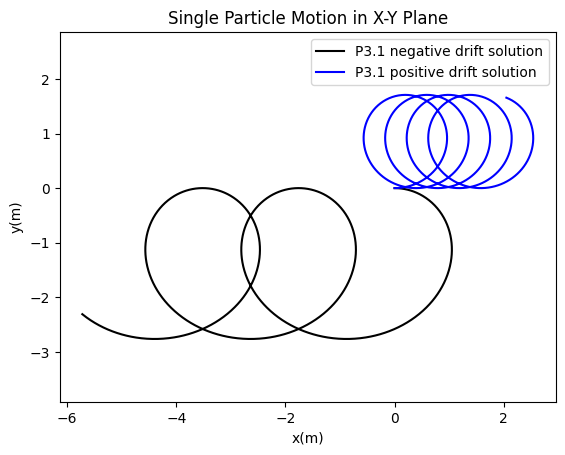

In [8]:
P311 = particle(q=1,m=1,name='P3.1 negative drift solution')
B31 = b_field(btype = 'gradB', mag = 1, beta = 0.2)
E31 = e_field(etype = 'null')
IC = (P311, E31, B31, np.array([0,0,0]), np.array([1,0,0]), 0, 24)
sim31 = simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

P312 = particle(q=-1,m=1,name='P3.1 positive drift solution')
IC = (P312, E31, B31, np.array([0,0,0]), np.array([1,0,0]), 0, 24)
sim31 = simulate(IC, axis = sim31, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y', overlay = True)


**P3.1 Solution**
>>
$
\displaystyle \vec{v}_{\nabla B} = \frac{1}{2}r_gv_\perp\frac{\vec{B}\times\nabla B}{B^2}\\
\vec{B} = B_0(1+0.2sy)\hat{k}\\
\to B = B_0(1+0.2sy)\\
$
>>
$
\displaystyle \to \nabla B = \frac{\partial B}{\partial x}\hat{\imath} + \frac{\partial B}{\partial y}\hat{\jmath} + \frac{\partial B}{\partial z}\hat{k} = \frac{\partial B_0(1+0.2sy)}{\partial x}\hat{\imath} + \frac{\partial B_0(1+0.2sy)}{\partial y}\hat{\jmath} + \frac{\partial B_0 (1+0.2sy)}{\partial z}\hat{k}\\
= 0\hat{\imath}+B_00.2s\hat{\jmath}+0\hat{k}
$
>>
$
\displaystyle \to \nabla B = B_00.2s\hat{\jmath}
$
>>
$
\displaystyle \vec{v}_{\nabla B}=\frac{1}{2}r_gv_\perp\frac{\vec{B}\times\nabla B}{B^2} = \frac{1}{2}r_gv_\perp\frac{B\hat{k}\times B_00.2s\hat{\jmath}}{B^2}=-\frac{1}{2}r_gv_\perp\frac{B_0}{B}0.2s\hat{\imath}=-\frac{1}{2}r_g\left(\frac{r_gqB}{m}\right)\frac{B_0}{B}0.2s\hat{\imath}\\
\displaystyle \to \vec{v}_{\nabla B} = -0.1s_g^2\left(\frac{qB_0}{m}\right)\hat{\imath}
$
>>
$s$ has the dimension m$^{-1}$ and $\frac{qB_0}{m}$ has the dimension rad/s. Changing the sign of $q$ reverses the direction of drift. When the drift is in the $+x$ direction the particle is in a stronger field which reduces the radius of gyration

(3.2) Decrease the field gradient by a factor of two and comment on the resultant effects on the particle trajectory.

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black


<Axes: title={'center': 'Single Particle Motion in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

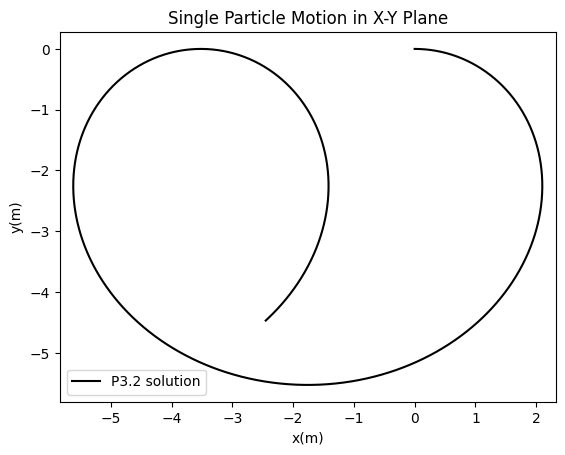

In [9]:
P32 = particle(q=1,m=1,name='P3.2 solution')
B32 = b_field(btype = 'gradB', mag = 0.5, beta = 0.1)
E32 = e_field(etype = 'null')
IC = (P32, E32, B32, np.array([0,0,0]), np.array([1,0,0]), 0, 24)
simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

**P3.2 Solution**
>>
Reducing the value of $s$ (in our case this is beta, an arbitrary variable) will result in a weaker magnetic field which will increase the radius of gyration.

(3.3) Write the explicit expression for the $\frac{dB_x}{dy}$ (from b_field.get_field) and calculate $\nabla B$-drift velocity for each case considered using $\vec{v}_{\nabla B} = \frac{1}{2}r_{L}v_{\perp}\frac{\vec{B}\times\nabla B}{B^2}$. Do the results of your analytical calculations agree with the trajectories obtained using PiF.py? What is the reason for observed differences.

<ipython-input-2-807d78d82adb>:175: RuntimeWarning: divide by zero encountered in scalar divide
  Tg = 2*pi/wg
<ipython-input-2-807d78d82adb>:160: RuntimeWarning: invalid value encountered in scalar divide
  vpp = linalg.norm(np.cross(V,B))/b
<ipython-input-2-807d78d82adb>:161: RuntimeWarning: invalid value encountered in scalar divide
  vpr = int(np.dot(V,B))/b


Simulation Running for 0 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black
Simulation Running for 0 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: blue


<Axes: title={'center': 'Single Particle Motion in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

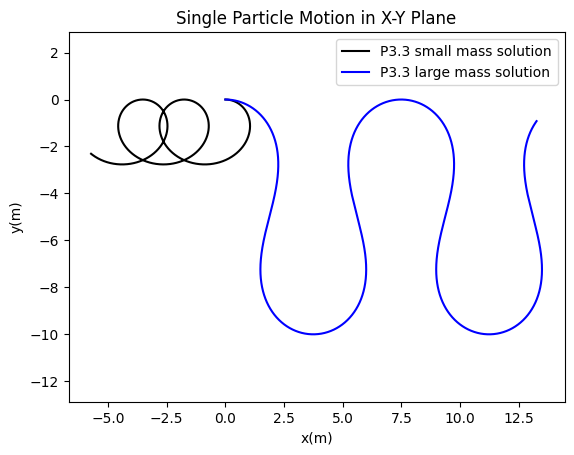

In [10]:
P331 = particle(q=1,m=1,name='P3.3 small mass solution')
B331 = b_field(btype = 'gradB', mag = 1, beta = 0.2)
E33 = e_field(etype = 'null')
IC = (P331, E33, B331, np.array([0,0,0]), np.array([1,0,0]), 0, 24)
sim33 = simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

P332 = particle(q=1,m=2,name='P3.3 large mass solution')
B332 = b_field(btype = 'gradB', mag = 1, beta = 0.2)
IC = (P332, E33, B332, np.array([0,0,0]), np.array([1,0,0]), 0, 48)
simulate(IC, axis = sim33, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y', overlay =True)

**P3.3 Solution**
>>
The previous derivations stands as long as $r << L$($L$ is the physical scale of the process), there will be a drift toward -$x$. Heavier particles have larger radii.

**(P4)** *(5 points)*

Consider the motion of a charged particle with charge $q=1$, mass $m=1$, in the homogeneous magnetic field $\vec{B}=1\hat{k}$. Assume that this particle starts at $\vec{r}(0)=1\hat{\imath}$ with the initial velocity $\vec{v}(0) = 1\hat{i}$. Add a non-uniform electric field $\vec{E}=E_0\cos{(\alpha x)}\hat{\imath}$, as a user-defined field configuration in e_field.get_field. Assume $E_0 = 0.1$.

(4.1) Compare to the case $\alpha = 0$ (i.e., uniform field) and $\alpha=\frac{0.5}{r_\perp}$ where $r_\perp$ is the Larmor radius of the unperterbed particle orbit.

Simulation Running for 2 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black
Simulation Running for 2 Gyro Period
Overlay: True, New plot: False, View: x-y, Color: blue


<Axes: title={'center': 'Single Particle Motion in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

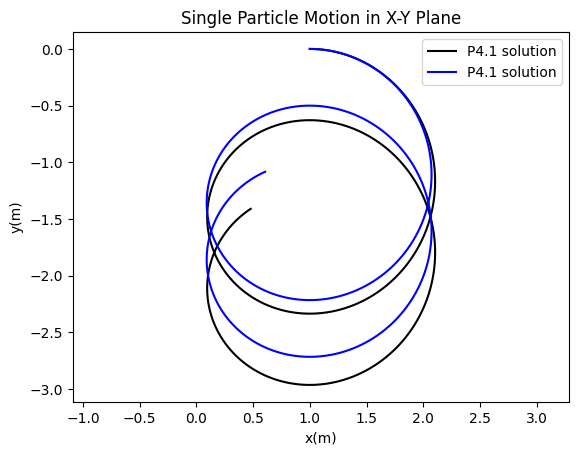

In [11]:
P41 = particle(q=1,m=1,name='P4.1 solution')
B41 = b_field(btype = 'Bz', mag = 1, beta = 0)
E411 = e_field(etype = 'user', mag = 0.1, alpha = 0)
IC = (P41, E411, B41, np.array([1,0,0]), np.array([1,0,0]), 0, 12)
sim41 = simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

E412 = e_field(etype = 'user', mag = 0.1, alpha = 0.5/1)
IC = (P41, E412, B41, np.array([1,0,0]), np.array([1,0,0]), 0, 12)
simulate(IC, axis = sim41, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y', overlay = True)

(4.2) Comment on physical reasons for th eobserved differences. Do results of your numerical experiments agree with the Larmor radius correction provided by [Chen, 2015, Ch.2]?

**P4.1/2 Solution**

>>


**(P5)** *(5 points)*

Consider the same initial condition as in **(P4)**, but with a user-defined uniform time dependent electric field in the form $\vec{E} = E_0(1+\alpha t)$. Assume $E_0=0.1$ and $\alpha=0.05$.

(5.1) Compare the polarization drift velocity parallel to the applied electric field estimated from your numerical experiment and results derived from expression [Chen, 2015, Ch.2].

(5.2) What is the physical reason for the observed particle drift in the x-direction?

**(P6)** *(5 points)*

Review the attached handouts, which provide background on the geomagnetic field. Consider the motion of a negatively charged particle $q=-1$, mass $m=1$ in a field of a magnetic dipole. The corresponding configuration is provided as one of the predefined options in PiF.py. Assume that $B_0 = -1$ to properly represent the direction of the field lines corresponding to the geomagnetic field.

(6.1) Assume that the particle starts at the point $\vec{r}(0)=1\hat{\imath}$ (i.e., in the equatorial plane) with initial velocity $\vec{v}(0) = 0.04(\hat{\imath}+\hat{\jmath})$. Inspect the particle trajectory in the *x-y* plane. What is the direction of the particle's guiding center drift? How does it relate to the particle sign , the direction of the magnetic field, and the direction of the magnetic field gradient?

Simulation Running for 207 Gyro Period
Overlay: False, New plot: True, View: x-y, Color: black


<Axes: title={'center': 'Single Particle Motion in X-Y Plane'}, xlabel='x(m)', ylabel='y(m)'>

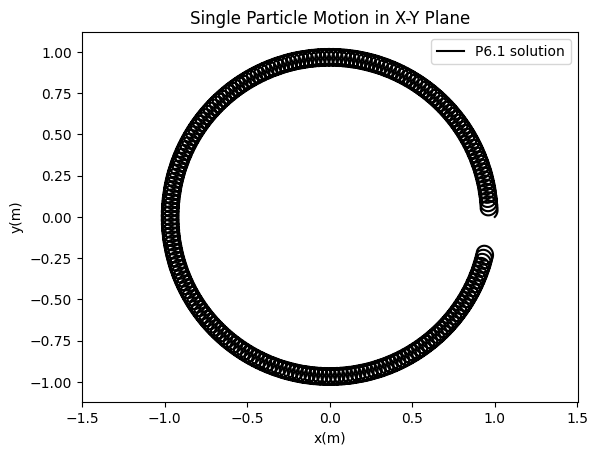

In [12]:
P61 = particle(q=-1,m=1,name='P6.1 solution')
B61 = b_field(btype = 'dipole', mag = -1, beta = 0)
E6 = e_field(etype = 'null')
IC = (P61, E6, B61, np.array([1,0,0]), np.array([0.04,0.04,0]), 0, 1300)
simulate(IC, speed = 'real', title = 'Single Particle Motion in X-Y Plane', view = 'x-y')

**P6.1 Solution**
>>
There is no $v_\parallel$ therefore there should only be drift due to $\nabla B$. In the equitorial plane, $\vec{B} = |\vec{B}|\hat{e}_z$ (upward) and $\nabla B = -|\nabla B|\vec{e}_r$ ($B\text{ decreases with } r$). Therefore:
>>
$\displaystyle\vec{v}_{\nabla B}=\pm\frac{1}{2}r_gv_\perp\frac{\vec{B}\times\nabla B}{B^2}=\pm\frac{1}{2}r_gv_\perp\frac{|\nabla B|}{\vec{B}}\hat{e}_z\times-\vec{e}_r$
>>
$\displaystyle\to\vec{v}_{\nabla B}=\mp\frac{1}{2}r_gv_\perp\frac{|\nabla B|}{\vec{B}}\hat{e}_\theta$
>>
The drift of the negative particle is along $\hat{e}_0$ i.e., counter-clockwise (Shown in figure). The small rotations in the figure are the gyromotions due to locall uniform magnetic field for particles with non-zero initial velocities.

(6.2) Change the particle initial velocity by introducing a component parallel to the magnetic field line $\vec{v}(0) = 0.04(\hat{\imath}+\hat{\jmath}) +0.07\hat{k}$. What is the reason for the observed mirroring points in the polar regions?

Simulation Running for 207 Gyro Period
Overlay: False, New plot: True, View: 3D, Color: black


<Axes3D: title={'center': 'Single Particle Motion in 3D orthographic'}, xlabel='x(m)', ylabel='y(m)', zlabel='z(m)'>

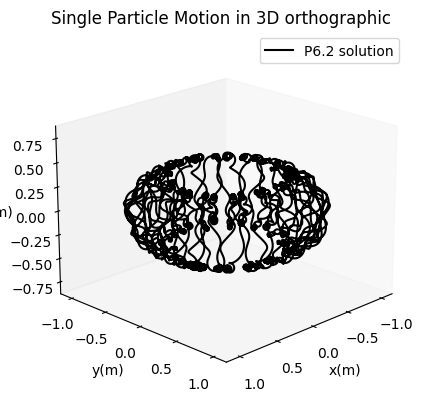

In [13]:
P62 = particle(q=-1,m=1,name='P6.2 solution')
B62 = b_field(btype = 'dipole', mag = -1, beta = 0)
IC = (P62, E6, B62, np.array([1,0,0]), np.array([0.04,0.04,0.07]), 0, 1300)
simulate(IC, speed = 'real', title = 'Single Particle Motion in 3D orthographic', view = '3D')

**P6.2 Solution**
>>
There is no $v_\parallel$ therefore there should be drift only from $\nabla B$. In the equitorial plane, $\vec{B}=|\vec{B}|\hat{e}_z$ (upward) and $\nabla B = -|\nabla B|\hat{e}_r$ ($B \text{ decreases with } r$). Therefore, if we add an initial parallel component to the velocity, we add the effect of a curvature drift givven by $\vec{v}_R=\frac{mv_\parallel^2}{q}\frac{\vec{R}_c\times\vec{B}}{R_cB^2}$, where $\vec{R}_c$ is the curvature radius vector. The curvature and $\nabla B$-drifts are properties of the magnetic field of a dipole and act together to create a magnetic mirror.